In [1]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nikolamilicevic. Use `wandb login --relogin` to force relogin


True

In [2]:
wandb.init(
    project="affinity",
    name="testing mha cross blocks",
    config={
        "batch_size": 8,
        "dataset": "testing_200k",
    },
)

In [5]:
# Data
# Created with csvcut -t -c "Ligand SMILES,BindingDB Target Chain Sequence,IC50 (nM)" BindingDB_All.tsv > BindingDB_fin.csv
import pandas as pd

df = pd.read_csv("BindingDB_fin.csv")

In [6]:
df

,Ligand SMILES,BindingDB Target Chain Sequence,IC50 (nM)
0,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,NaN
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,NaN
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,NaN
3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,NaN
4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,NaN
...,...,...,...
2937446,CC[C@H]1CN(Cc2cc(C)cc(CC(O)=O)c2)CCN1c1nc2ccc(...,MGETLGDSPVDPEHGAFADALPMSTSQEITMVDTEMPFWPTNFGIS...,NaN
2937447,CC[C@@H]1CN(Cc2cc(C)cc(CC(O)=O)c2)CCN1c1nc2ccc...,MGETLGDSPVDPEHGAFADALPMSTSQEITMVDTEMPFWPTNFGIS...,NaN
2937448,CC(C)[C@@H]1CN(Cc2cc(C)cc(CC(O)=O)c2)CCN1c1nc2...,MGETLGDSPVDPEHGAFADALPMSTSQEITMVDTEMPFWPTNFGIS...,NaN
2937449,COc1ccc(cc1)N(C)c1nc(C)nc2[nH]ccc12,CVSASPSTLARLVSRSAMPAGSSTAWNTAFSPMARCQVTKTIGGGD...,2600


In [4]:
# FOR TESTING PURPOSES REDUCE DATASET SIZE
df = df.sample(n=10_000, random_state=42)

In [2]:
import numpy as np

df = df.rename(columns={"Ligand SMILES": "ligand", "BindingDB Target Chain Sequence": "protein", "IC50 (nM)": "ic50"})
ic50 = df['ic50'][~df['ic50'].isna()]
less_than = ic50.str.contains("<")
greater_than = ic50.str.contains(">")
ic50 = ic50[~(less_than | greater_than)]
ic50n = ic50.astype(float)
df = df.loc[ic50n.index]
#  IC50 values are logarithmic in nature;
# a compound with an IC50 of 10 nM is 10x more potent than one with 100 nM
df['ic50'] = ic50n

In [3]:
df = df[df['ic50'] != 0.0]
df.loc[:, 'ic50'] = np.log(df['ic50'])

In [4]:
print(f"Ligands total: {len(df['ligand'].values)}")
print(f"Ligands unique {len(set(df['ligand'].values))}")
print(f"Proteins total {len(df['protein'].values)}")
print(f"Proteins unique {len(set(df['protein'].values))}")

Ligands total: 1562952
Ligands unique 819232
Proteins total 1562952
Proteins unique 6475


In [8]:
# BASELINE DUMMY MODEL 
# that predicts mean of ic50
import numpy as np
import torch
import torch.nn as nn
mean_ic50 = np.mean(df['ic50'])
y_pred_dummy = np.full_like(df['ic50'], mean_ic50)
loss = nn.MSELoss()
loss(torch.tensor(y_pred_dummy), torch.tensor(df['ic50'].values))

tensor(10.5597, dtype=torch.float64)

In [9]:
import datasets
dataset = datasets.Dataset.from_pandas(df.reset_index(drop=True))
dataset

Dataset({
    features: ['ligand', 'protein', 'ic50'],
    num_rows: 5339
})

In [10]:
type(ic50n)

pandas.core.series.Series

<Axes: xlabel='ic50', ylabel='Count'>

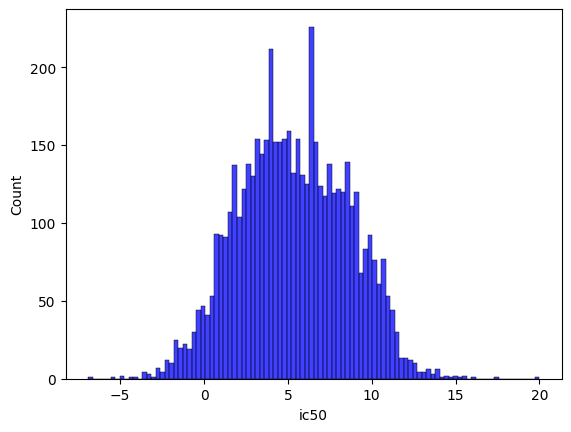

In [29]:
import seaborn as sns
import numpy as np

# sns.histplot(df['ic50'], bins=100, color='blue')
# sns.histplot(ic50n, bins=100, color='blue')


In [12]:
# from transformers import AutoTokenizer, AutoModel

# chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
# chem_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# esm_model_name = "facebook/esm2_t33_650M_UR50D"
# esm_tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
# esm_model = AutoModel.from_pretrained(esm_model_name)
# seyonec/ChemBERTa-zinc250k-v1

In [13]:
# print(torch.cuda.memory_reserved()/(1024*1024))
# print(torch.cuda.memory_allocated()/(1024*1024))

In [14]:
# esm_tokenizer.decode(esm_input['input_ids'][0])
# esm_tokenizer.eos_token_id

In [15]:
# chem_tokenizer.decode(chem_inputs['input_ids'][0])

In [16]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding
import torch.nn.functional as F

    
class BindingAffinityModel(nn.Module):
    def __init__(self, esm_model_name, chem_model_name, combined_embedding_dim=512):
        super().__init__()
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load pretrained ESM2 model for proteins
        self.esm_model = AutoModel.from_pretrained(esm_model_name)
        self.esm_tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
        self.esm_model.eval()
        
        # Load pretrained ChemLLM for SMILES (ligands)
        self.chem_model = AutoModel.from_pretrained(chem_model_name)
        self.chem_tokenizer = AutoTokenizer.from_pretrained(chem_model_name)
        self.chem_model.eval()

        # Disable gradient computation for both base models
        for param in self.esm_model.parameters():
            param.requires_grad = False

        for param in self.chem_model.parameters():
            param.requires_grad = False
        
        # Protein and SMILES embedding dimensions
        self.protein_embedding_dim = self.esm_model.config.hidden_size
        self.chem_embedding_dim = self.chem_model.config.hidden_size
        
        # Projection layers to ensure same dimensionality
        # self.protein_projector = nn.Linear(self.protein_embedding_dim, combined_embedding_dim)
        # self.chem_projector = nn.Linear(self.chem_embedding_dim, combined_embedding_dim)
        
        # Combine embeddings
        # self.combined_embedding_dim = combined_embedding_dim * 2
        self.fc_combine = nn.Linear(self.protein_embedding_dim + self.chem_embedding_dim, combined_embedding_dim)
        # self.fc_additional = nn.Linear(combined_embedding_dim, combined_embedding_dim)
        self.fc_out = nn.Linear(combined_embedding_dim, 1)  # Predict IC50 as a single value
        
    def forward(
            self,
            ligand_input_ids,
            ligand_attention_mask,
            protein_input_ids,
            protein_attention_mask
        ):
        # Protein embedding
        # protein_inputs = self.esm_tokenizer(protein_sequence, return_tensors="pt")
        protein_inputs = {
            "input_ids": protein_input_ids,
            "attention_mask": protein_attention_mask
        }
        # perform in FP16 for lower memory usage (matmuls)
        with torch.cuda.amp.autocast():
            with torch.no_grad():
                protein_outputs = self.esm_model(**protein_inputs)
        special_tokens_mask = (protein_inputs['input_ids'] == self.esm_tokenizer.cls_token_id)\
        | (protein_inputs['input_ids'] == self.esm_tokenizer.eos_token_id)\
        | (protein_inputs['input_ids'] == self.esm_tokenizer.pad_token_id)
        valid_tokens_mask = ~special_tokens_mask
        protein_embedding = (protein_outputs.last_hidden_state * valid_tokens_mask.unsqueeze(dim=-1)).mean(dim=1)
        # protein_embedding = self.protein_projector(protein_embedding)  # Project to combined_embedding_dim
        
        # SMILES embedding
        # chem_inputs = self.chem_tokenizer(ligand_smiles, return_tensors="pt", add_special_tokens=True)
        chem_inputs = {
            "input_ids": ligand_input_ids,
            "attention_mask": ligand_attention_mask
        }
        special_tokens_mask = (chem_inputs['input_ids'] == self.chem_tokenizer.bos_token_id)\
        | (chem_inputs['input_ids'] == self.chem_tokenizer.eos_token_id)\
        | (chem_inputs['input_ids'] == self.chem_tokenizer.pad_token_id)
        valid_tokens_mask = ~special_tokens_mask

        with torch.cuda.amp.autocast():
            with torch.no_grad():
                chem_outputs = self.chem_model(**chem_inputs)
        chem_embedding = (chem_outputs.last_hidden_state * valid_tokens_mask.unsqueeze(dim=-1)).mean(dim=1)
        # chem_embedding = self.chem_projector(chem_embedding)  # Project to combined_embedding_dim
        
        # Combine embeddings (already projected)
        x = torch.cat([protein_embedding, chem_embedding], dim=1)
        x = F.relu(self.fc_combine(x))
        # x = F.relu(self.fc_additional(x))
        # Output layer
        binding_affinity = self.fc_out(x)
        return binding_affinity

class BindingAffinityModelWithAttention(nn.Module):
    def __init__(self, esm_model_name, chem_model_name, combined_embedding_dim=512, attention_dim=256):
        super().__init__()
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load pretrained ESM2 model for proteins
        self.esm_model = AutoModel.from_pretrained(esm_model_name)
        self.esm_tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
        self.esm_model.eval()
        
        # Load pretrained ChemLLM for SMILES (ligands)
        self.chem_model = AutoModel.from_pretrained(chem_model_name)
        self.chem_tokenizer = AutoTokenizer.from_pretrained(chem_model_name)
        self.chem_model.eval()

        # Disable gradient computation for both base models
        for param in self.esm_model.parameters():
            param.requires_grad = False

        for param in self.chem_model.parameters():
            param.requires_grad = False
        
        # Protein and SMILES embedding dimensions
        self.protein_embedding_dim = self.esm_model.config.hidden_size
        self.chem_embedding_dim = self.chem_model.config.hidden_size
        
        # Linear layers to process individual embeddings
        self.protein_linear = nn.Linear(self.protein_embedding_dim, attention_dim)
        self.ligand_linear = nn.Linear(self.chem_embedding_dim, attention_dim)
        
        # Attention layer
        self.attention = nn.Linear(attention_dim, 1)
        
        # Combined processing layers
        self.combined_linear = nn.Linear(self.protein_embedding_dim + self.chem_embedding_dim, combined_embedding_dim)
        self.output_layer = nn.Linear(combined_embedding_dim, 1)
        
    def forward(
            self,
            ligand_input_ids,
            ligand_attention_mask,
            protein_input_ids,
            protein_attention_mask
        ):
        # Protein embedding
        # protein_inputs = self.esm_tokenizer(protein_sequence, return_tensors="pt")
        protein_inputs = {
            "input_ids": protein_input_ids,
            "attention_mask": protein_attention_mask
        }
        # perform in FP16 for lower memory usage (matmuls)
        with torch.cuda.amp.autocast():
            with torch.no_grad():
                protein_outputs = self.esm_model(**protein_inputs)
        special_tokens_mask = (protein_inputs['input_ids'] == self.esm_tokenizer.cls_token_id)\
        | (protein_inputs['input_ids'] == self.esm_tokenizer.eos_token_id)\
        | (protein_inputs['input_ids'] == self.esm_tokenizer.pad_token_id)
        valid_tokens_mask = ~special_tokens_mask
        protein_embedding = (protein_outputs.last_hidden_state * valid_tokens_mask.unsqueeze(dim=-1)).mean(dim=1)
        # protein_embedding = self.protein_projector(protein_embedding)  # Project to combined_embedding_dim
        
        # SMILES embedding
        # chem_inputs = self.chem_tokenizer(ligand_smiles, return_tensors="pt", add_special_tokens=True)
        chem_inputs = {
            "input_ids": ligand_input_ids,
            "attention_mask": ligand_attention_mask
        }
        special_tokens_mask = (chem_inputs['input_ids'] == self.chem_tokenizer.bos_token_id)\
        | (chem_inputs['input_ids'] == self.chem_tokenizer.eos_token_id)\
        | (chem_inputs['input_ids'] == self.chem_tokenizer.pad_token_id)
        valid_tokens_mask = ~special_tokens_mask

        with torch.cuda.amp.autocast():
            with torch.no_grad():
                chem_outputs = self.chem_model(**chem_inputs)
        chem_embedding = (chem_outputs.last_hidden_state * valid_tokens_mask.unsqueeze(dim=-1)).mean(dim=1)
        # chem_embedding = self.chem_projector(chem_embedding)  # Project to combined_embedding_dim
        
        # transform into common dimension
        protein_attention = self.protein_linear(protein_embedding)
        ligand_attention = self.ligand_linear(chem_embedding)

        # compute attention used for both protein and ligand embeddings
        combined_attention = F.relu(protein_attention + ligand_attention)
        attention_scores = F.softmax(self.attention(combined_attention), dim=0)

        # apply attention
        attended_protein = protein_embedding * attention_scores  # Weighted protein embedding
        attended_ligand = chem_embedding * attention_scores

        # concatenate embeddings
        combined = torch.cat([attended_protein, attended_ligand], dim=1)

        # pass through hidden layer
        combined_features = F.relu(self.combined_linear(combined))

        # predict ic50 
        ic50_prediction = self.output_layer(combined_features)

        return ic50_prediction

class BindingAffinityModelWithCrossAttention(nn.Module):
    def __init__(self, esm_model_name, chem_model_name, combined_embedding_dim=512, attention_dim=256):
        super().__init__()
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load pretrained ESM2 model for proteins
        self.esm_model = AutoModel.from_pretrained(esm_model_name)
        self.esm_tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
        self.esm_model.eval()
        
        # Load pretrained ChemLLM for SMILES (ligands)
        self.chem_model = AutoModel.from_pretrained(chem_model_name)
        self.chem_tokenizer = AutoTokenizer.from_pretrained(chem_model_name)
        self.chem_model.eval()

        # Disable gradient computation for both base models
        for param in self.esm_model.parameters():
            param.requires_grad = False

        for param in self.chem_model.parameters():
            param.requires_grad = False
        
        # Protein and SMILES embedding dimensions
        self.protein_embedding_dim = self.esm_model.config.hidden_size
        self.chem_embedding_dim = self.chem_model.config.hidden_size
        
        # Protein queries ligand
        self.protein_query = nn.Linear(self.protein_embedding_dim, attention_dim)
        self.ligand_key = nn.Linear(self.chem_embedding_dim, attention_dim)
        self.ligand_value = nn.Linear(self.chem_embedding_dim, attention_dim)

        # Ligand queries protein
        self.ligand_query = nn.Linear(self.chem_embedding_dim, attention_dim)
        self.protein_key = nn.Linear(self.protein_embedding_dim, attention_dim)
        self.protein_value = nn.Linear(self.protein_embedding_dim, attention_dim)

        self.combined_linear = nn.Linear(self.protein_embedding_dim + self.chem_embedding_dim + 2 * attention_dim, combined_embedding_dim)
        self.output_layer = nn.Linear(combined_embedding_dim, 1)

    def cross_attention(self, key, query, value):
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / torch.sqrt(torch.tensor(key.size(-1), dtype=torch.float32))
        attention_weights = torch.softmax(attention_scores, dim=-1)
        return torch.matmul(attention_weights, value)
        
    def forward(
            self,
            ligand_input_ids,
            ligand_attention_mask,
            protein_input_ids,
            protein_attention_mask
        ):
        # Protein embedding
        # protein_inputs = self.esm_tokenizer(protein_sequence, return_tensors="pt")
        protein_inputs = {
            "input_ids": protein_input_ids,
            "attention_mask": protein_attention_mask
        }
        # perform in FP16 for lower memory usage (matmuls)
        with torch.cuda.amp.autocast():
            with torch.no_grad():
                protein_outputs = self.esm_model(**protein_inputs)
        special_tokens_mask = (protein_inputs['input_ids'] == self.esm_tokenizer.cls_token_id)\
        | (protein_inputs['input_ids'] == self.esm_tokenizer.eos_token_id)\
        | (protein_inputs['input_ids'] == self.esm_tokenizer.pad_token_id)
        valid_tokens_mask = ~special_tokens_mask
        protein_embedding = (protein_outputs.last_hidden_state * valid_tokens_mask.unsqueeze(dim=-1)).mean(dim=1)
        # protein_embedding = self.protein_projector(protein_embedding)  # Project to combined_embedding_dim
        
        # SMILES embedding
        # chem_inputs = self.chem_tokenizer(ligand_smiles, return_tensors="pt", add_special_tokens=True)
        chem_inputs = {
            "input_ids": ligand_input_ids,
            "attention_mask": ligand_attention_mask
        }
        special_tokens_mask = (chem_inputs['input_ids'] == self.chem_tokenizer.bos_token_id)\
        | (chem_inputs['input_ids'] == self.chem_tokenizer.eos_token_id)\
        | (chem_inputs['input_ids'] == self.chem_tokenizer.pad_token_id)
        valid_tokens_mask = ~special_tokens_mask

        with torch.cuda.amp.autocast():
            with torch.no_grad():
                chem_outputs = self.chem_model(**chem_inputs)
        chem_embedding = (chem_outputs.last_hidden_state * valid_tokens_mask.unsqueeze(dim=-1)).mean(dim=1)
        # chem_embedding = self.chem_projector(chem_embedding)  # Project to combined_embedding_dim
        
        # cross attention protein queries ligand
        prot_Q = self.protein_query(protein_embedding)
        ligand_K = self.ligand_key(chem_embedding)
        ligand_V = self.ligand_value(chem_embedding)
        attended_ligand = self.cross_attention(prot_Q, ligand_K, ligand_V)

        # cross attention ligand queries protein
        ligand_Q = self.ligand_query(chem_embedding)
        protein_K = self.protein_key(protein_embedding)
        protein_V = self.protein_value(protein_embedding)
        attended_protein = self.cross_attention(ligand_Q, protein_K, protein_V)

        # Combine embeddings
        combined = torch.cat([protein_embedding, chem_embedding, attended_ligand, attended_protein], dim=1)
        combined_features = torch.relu(self.combined_linear(combined))
        ic50_prediction = self.output_layer(combined_features)
        return ic50_prediction

# MultiHeadCrossAttention  
class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, dropout=0.1, ffn_hidden_dim=2048):
        super(CrossAttentionLayer, self).__init__()
        self.protein_to_ligand_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ligand_to_protein_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        ffn_hidden_dim = embed_dim * 3
        self.ffn_protein = nn.Sequential(
            nn.Linear(embed_dim, ffn_hidden_dim),
            nn.ReLU(),  # Non-linear activation
            nn.Linear(ffn_hidden_dim, embed_dim),
        )
        self.ffn_ligand = nn.Sequential(
            nn.Linear(embed_dim, ffn_hidden_dim),
            nn.ReLU(),  # Non-linear activation
            nn.Linear(ffn_hidden_dim, embed_dim),
        )
        self.protein_norm = nn.LayerNorm(embed_dim)
        self.ligand_norm = nn.LayerNorm(embed_dim)
        self.ffn_protein_norm = nn.LayerNorm(embed_dim)
        self.ffn_ligand_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, protein_embedding, ligand_embedding, key_pad_mask_prot, key_pad_mask_ligand):
        # Protein attending to ligand
        attended_protein, _ = self.protein_to_ligand_attention(
            query=protein_embedding, 
            key=ligand_embedding,
            value=ligand_embedding,
            key_padding_mask=key_pad_mask_ligand
        )
        attended_protein = self.protein_norm(protein_embedding + attended_protein)  # Residual connection
        x_prot = self.ffn_protein(attended_protein)
        x_prot = self.ffn_protein_norm(attended_protein + self.dropout(x_prot))

        # Ligand attending to protein
        attended_ligand, _ = self.ligand_to_protein_attention(
            query=ligand_embedding, 
            key=protein_embedding, 
            value=protein_embedding,
            key_padding_mask=key_pad_mask_prot
        )
        attended_ligand = self.ligand_norm(ligand_embedding + attended_ligand)  # Residual connection
        x_ligand = self.ffn_ligand(attended_ligand)
        x_ligand = self.ffn_ligand_norm(attended_ligand + self.dropout(x_ligand))
        return x_prot, x_ligand

class BindingAffinityModelWithMultiHeadCrossAttention(nn.Module):
    def __init__(self, esm_model_name, chem_model_name, num_layers=3, hidden_dim=1024):
        super().__init__()
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load pretrained ESM2 model for proteins
        self.esm_model = AutoModel.from_pretrained(esm_model_name)
        self.esm_tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
        self.esm_model.eval()
        
        # Load pretrained ChemLLM for SMILES (ligands)
        self.ligand_model = AutoModel.from_pretrained(chem_model_name)
        self.ligand_tokenizer = AutoTokenizer.from_pretrained(chem_model_name)
        self.ligand_model.eval()

        # Disable gradient computation for both base models
        for param in self.esm_model.parameters():
            param.requires_grad = False

        for param in self.ligand_model.parameters():
            param.requires_grad = False
        
        # Protein and SMILES embedding dimensions
        self.protein_embedding_dim = self.esm_model.config.hidden_size
        self.ligand_embedding_dim = self.ligand_model.config.hidden_size

        self.project_to_common = nn.Linear(self.protein_embedding_dim, self.ligand_embedding_dim)

        self.layers = nn.ModuleList([
            CrossAttentionLayer(embed_dim=self.ligand_embedding_dim) for _ in range(num_layers)
        ])

        self.ffn_ic50 = nn.Sequential(
            nn.Linear(2 * self.ligand_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        
    def forward(
            self,
            ligand_input_ids,
            ligand_attention_mask,
            protein_input_ids,
            protein_attention_mask
        ):
        # Protein embedding
        # protein_inputs = self.esm_tokenizer(protein_sequence, return_tensors="pt")
        protein_inputs = {
            "input_ids": protein_input_ids,
            "attention_mask": protein_attention_mask
        }
        # perform in FP16 for lower memory usage (matmuls)
        with torch.cuda.amp.autocast():
            with torch.no_grad():
                protein_outputs = self.esm_model(**protein_inputs)
        special_tokens_mask_prot = (protein_inputs['input_ids'] == self.esm_tokenizer.cls_token_id)\
        | (protein_inputs['input_ids'] == self.esm_tokenizer.eos_token_id)\
        | (protein_inputs['input_ids'] == self.esm_tokenizer.pad_token_id)
        protein_embedding = protein_outputs.last_hidden_state
        
        # SMILES embedding
        ligand_inputs = {
            "input_ids": ligand_input_ids,
            "attention_mask": ligand_attention_mask
        }
        special_tokens_mask_ligand = (ligand_inputs['input_ids'] == self.ligand_tokenizer.bos_token_id)\
        | (ligand_inputs['input_ids'] == self.ligand_tokenizer.eos_token_id)\
        | (ligand_inputs['input_ids'] == self.ligand_tokenizer.pad_token_id)

        with torch.cuda.amp.autocast():
            with torch.no_grad():
                ligand_outputs = self.ligand_model(**ligand_inputs)
        ligand_embedding = ligand_outputs.last_hidden_state

        # project embeddings to same dimension
        protein_embedding = self.project_to_common(protein_embedding)
        
        for layer in self.layers:
            protein_embedding, ligand_embedding = layer(protein_embedding, ligand_embedding, special_tokens_mask_prot, special_tokens_mask_ligand)

        # Perform mean pooling
        ligand_embedding = (ligand_embedding * ~special_tokens_mask_ligand.unsqueeze(dim=-1)).mean(dim=1)
        protein_embedding = (protein_embedding * ~special_tokens_mask_prot.unsqueeze(dim=-1)).mean(dim=1)
        # Combine embeddings
        combined = torch.cat([protein_embedding, ligand_embedding], dim=1)
        ic50_prediction = self.ffn_ic50(combined)
        return ic50_prediction


esm_model_name = "facebook/esm2_t33_650M_UR50D"  # Replace with the correct ESM2 model name
chem_model_name = "seyonec/ChemBERTa-zinc-base-v1" # Replace with the correct ChemLLM model name


In [17]:
print(f"Maximum ligand length {df['ligand'].str.len().max()}")
print(f"Minimum ligand length {df['ligand'].str.len().min()}")
print(f"Mean ligand length {df['ligand'].str.len().mean():.2f}")
print(f"Median ligand length {df['ligand'].str.len().median()}")
print(f"Maximum protein length {df['protein'].str.len().max()}")
print(f"Minimum protein length {df['protein'].str.len().min()}")
print(f"Mean protein length {df['protein'].str.len().mean():.2f}")
print(f"Median protein length {df['protein'].str.len().median()}")

Maximum ligand length 698
Minimum ligand length 8
Mean ligand length 60.49
Median ligand length 57.0
Maximum protein length 7132
Minimum protein length 9
Mean protein length 733.63
Median protein length 545.0


In [18]:
# Data split 
from datasets import DatasetDict

# Filter protein sequences longer than 1024 and ligands longer than 512
dataset = dataset.filter(lambda x: len(x["protein"]) < 1024)
dataset = dataset.filter(lambda x: len(x["ligand"]) < 512)

dataset_train_test = dataset.train_test_split(test_size=0.2)
dataset_test_val = dataset_train_test["test"].train_test_split(test_size=0.5)
dataset_dict = {
    "train": dataset_train_test['train'],
    "test": dataset_test_val["train"],
    "validation": dataset_test_val['test']
}
dataset = DatasetDict(dataset_dict)
dataset


Filter:   0%|          | 0/5339 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4205 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ligand', 'protein', 'ic50'],
        num_rows: 3360
    })
    test: Dataset({
        features: ['ligand', 'protein', 'ic50'],
        num_rows: 420
    })
    validation: Dataset({
        features: ['ligand', 'protein', 'ic50'],
        num_rows: 421
    })
})

In [19]:
# Tokenization of ligands and protein sequences
chem_tokenizer = AutoTokenizer.from_pretrained(chem_model_name)
esm_tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
print(f"chem tokenizer is fast: {chem_tokenizer.is_fast}")
print(f"esm tokenizer is fast: {esm_tokenizer.is_fast}")

def tokenize_ligands(examples):
    toks = chem_tokenizer(examples["ligand"], truncation=True)
    return {
        "ligand_input_ids": toks["input_ids"],
        "ligand_attention_mask": toks["attention_mask"]
    }

def tokenize_proteins(examples):
    toks =  esm_tokenizer(examples["protein"], truncation=True)
    return {
        "protein_input_ids": toks["input_ids"],
        "protein_attention_mask": toks["attention_mask"]
    }

tokenized_dataset = dataset.map(tokenize_proteins, batched=True)
tokenized_dataset = tokenized_dataset.map(tokenize_ligands, batched=True)
tokenized_dataset

chem tokenizer is fast: True
esm tokenizer is fast: False


Map:   0%|          | 0/3360 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/421 [00:00<?, ? examples/s]

Map:   0%|          | 0/3360 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/421 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ligand', 'protein', 'ic50', 'protein_input_ids', 'protein_attention_mask', 'ligand_input_ids', 'ligand_attention_mask'],
        num_rows: 3360
    })
    test: Dataset({
        features: ['ligand', 'protein', 'ic50', 'protein_input_ids', 'protein_attention_mask', 'ligand_input_ids', 'ligand_attention_mask'],
        num_rows: 420
    })
    validation: Dataset({
        features: ['ligand', 'protein', 'ic50', 'protein_input_ids', 'protein_attention_mask', 'ligand_input_ids', 'ligand_attention_mask'],
        num_rows: 421
    })
})

In [20]:
# Custom data collator
from transformers import DataCollatorWithPadding

chem_collator = DataCollatorWithPadding(tokenizer=chem_tokenizer)
esm_collator = DataCollatorWithPadding(tokenizer=esm_tokenizer)

class CustomDataCollator:
    def __init__(self, chem_collator, esm_collator):
            self.chem_collator = chem_collator
            self.esm_collator = esm_collator

    def __call__(self, batch):
        batch_ligand = [{"input_ids": b["ligand_input_ids"], "attention_mask": b["ligand_attention_mask"]} for b in batch]
        batch_protein = [{"input_ids": b["protein_input_ids"], "attention_mask": b["protein_attention_mask"]} for b in batch]

        collated_chem = self.chem_collator(batch_ligand)
        collated_esm = self.esm_collator(batch_protein)

        return {
            "ligand_input_ids": collated_chem["input_ids"],
            "ligand_attention_mask": collated_chem["attention_mask"],
            "protein_input_ids": collated_esm["input_ids"],
            "protein_attention_mask": collated_esm["attention_mask"],
            "ic50": torch.tensor([x['ic50'] for x in batch])
        }

In [21]:
from torch.utils.data import DataLoader

bs = 32
collator = CustomDataCollator(chem_collator=chem_collator, esm_collator=esm_collator)
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=bs, collate_fn=collator)
test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=bs, collate_fn=collator)
val_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=bs, collate_fn=collator)

In [22]:
# # TESTING MEMORY WITH SINGLE BATCH
# batch = next(iter(train_dataloader))
# batch["ligand_input_ids"]
# chem_inputs = {
#             "input_ids": batch["ligand_input_ids"].to(device),
#             "attention_mask": batch["ligand_attention_mask"].to(device)
#         }
# prot_inputs = {
#             "input_ids": batch["protein_input_ids"].to(device),
#             "attention_mask": batch["protein_attention_mask"].to(device)
#         }
# o = esm_model(**prot_inputs)
# o['last_hidden_state'].shape

In [23]:
# Training loop 
import torch.nn as nn
from tqdm import tqdm

WARMUP_STEPS = 200
EPOCHS = 1

def lr_lambda(step):
    if step < WARMUP_STEPS:
        # Linear warmup
        return step / WARMUP_STEPS
    else:
        remaining_steps = total_steps - WARMUP_STEPS
        decay_step = step - WARMUP_STEPS
        return max(0.0, 1.0 - decay_step / remaining_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
model = BindingAffinityModelWithMultiHeadCrossAttention(esm_model_name, chem_model_name).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
total_steps = EPOCHS * len(train_dataloader)


def train_model(model, train_dataloader, val_dataloader):
    step = 0

    for epoch in range(EPOCHS):
        print(f"Epoch: {epoch + 1}/{EPOCHS}")
        model.train()
        train_loss = 0.0
        train_progress = tqdm(train_dataloader, desc="Training")

        for batch in train_progress:
            ligand_input_ids = batch["ligand_input_ids"].to(device)
            ligand_attention_mask = batch["ligand_attention_mask"].to(device)
            protein_input_ids = batch["protein_input_ids"].to(device)
            protein_attention_mask = batch["protein_attention_mask"].to(device)
            targets = batch["ic50"].unsqueeze(dim=-1).to(device)
            optimizer.zero_grad()
            preds = model(ligand_input_ids, ligand_attention_mask, protein_input_ids, protein_attention_mask)
            loss = criterion(preds, targets)
            loss.backward()
            train_loss += loss.item()
            step += 1
            optimizer.step()
            scheduler.step()

            if step % 100 == 0:
                wandb.log({"train_loss": loss.item()})
                wandb.log({"lr": optimizer.param_groups[0]["lr"]})

        train_loss /= len(train_dataloader)
        print(f"Epoch: {epoch} Train loss: {train_loss}")

        step = 0
        model.eval()
        val_loss = 0.0
        val_progress = tqdm(val_dataloader, desc="Validation")
        with torch.no_grad():
            for batch in val_progress:
                ligand_input_ids = batch["ligand_input_ids"].to(device)
                ligand_attention_mask = batch["ligand_attention_mask"].to(device)
                protein_input_ids = batch["protein_input_ids"].to(device)
                protein_attention_mask = batch["protein_attention_mask"].to(device)
                targets = batch["ic50"].unsqueeze(dim=-1).to(device)
                preds = model(ligand_input_ids, ligand_attention_mask, protein_input_ids, protein_attention_mask)
                loss = criterion(preds, targets)
                val_loss += loss.item()
                step += 1
                if step % 10 == 0:
                    wandb.log({"val_loss": loss.item()})
                
        val_loss /= len(val_dataloader)
        scheduler.step(val_loss)
        print(f"Epoch: {epoch} Val loss: {val_loss}")

Using device cuda


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
train_model(model, train_dataloader, test_dataloader)

Epoch: 1/1


Training: 100%|██████████| 105/105 [04:34<00:00,  2.61s/it]


Epoch: 0 Train loss: 19.98928334372384


Validation: 100%|██████████| 14/14 [00:27<00:00,  1.99s/it]

Epoch: 0 Val loss: 14.828462055751256


In [25]:
torch.save(model.state_dict(), "affinity.pt")

In [26]:
# Evaluation on test set 
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    test_progress = tqdm(test_loader, desc="Test set")
    with torch.no_grad():
        for batch in test_progress:
            ligand_input_ids = batch["ligand_input_ids"].to(device)
            ligand_attention_mask = batch["ligand_attention_mask"].to(device)
            protein_input_ids = batch["protein_input_ids"].to(device)
            protein_attention_mask = batch["protein_attention_mask"].to(device)
            targets = batch["ic50"].unsqueeze(dim=-1).to(device)
            preds = model(ligand_input_ids, ligand_attention_mask, protein_input_ids, protein_attention_mask)
            all_targets.append(targets)
            all_predictions.append(preds)

    all_predictions = torch.cat(all_predictions)
    all_targets = torch.cat(all_targets)

    loss = torch.nn.MSELoss()
    print(f"Test set mean squared error: {loss(all_predictions, all_targets)}")
            

In [27]:
evaluate_model(model, test_loader=test_dataloader)

Test set: 100%|██████████| 14/14 [00:27<00:00,  1.96s/it]

Test set mean squared error: 13.255571365356445
